In [6]:
#import image from the computer
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import imageio
from findpeaks import findpeaks
import scipy as sp

volume_properties= []

In [7]:
# current functions

def count_pixels(saved_masked_img):
    pixel_total_masked = 0
    for i in range(0, saved_masked_img.shape[0]):
        for j in range(0, saved_masked_img.shape[1]):
            if saved_masked_img[i][j][0] != 0:
                pixel_total_masked += 1
    return pixel_total_masked


def thresholding(threshold, historgram):
    pulse_start_end= []
    hist_pulse_area= []
    hist_tr= historgram > threshold
    hist_tr = hist_tr.astype(int)

    hist_total_pulse_area= np.sum(hist_tr)
   # add tolerance to the thresholding
    max_tol= 3
    tol1=0
    tol2=0
    for i in range(1, len(hist_tr)):
        if hist_tr[i] == 1 and hist_tr[i-1] == 0:
            tol1=tol1 + 1
            if tol1==max_tol:
                pulse_start_end.append(i)
                tol1=0
        if hist_tr[i] == 0 and hist_tr[i-1] == 1:
            tol2=tol2 + 1
            if tol2==max_tol:
                pulse_start_end.append(i)
                tol2=0

    for i in range(0, len(pulse_start_end)//2 ):
        hist_pulse_area.append(np.sum(hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i+1]]))
        hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i +1]] = hist_pulse_area[i]
    return hist_tr, hist_pulse_area, pulse_start_end

def make_new_image(rgb_img, mask):
    red = rgb_img[:,:,0]*mask
    green = rgb_img[:,:,1]*mask
    blue = rgb_img[:,:,2]*mask
    masked_img = np.dstack((red,green,blue))
    return masked_img
    


In [34]:
def extract_color(hue_material_number,masked_img, hue, show_graphs=False):
    masked_hsv_img = cv.cvtColor(masked_img, cv.COLOR_RGB2HSV)
    total_pixels_masked= count_pixels(masked_hsv_img)
    if total_pixels_masked <= 15:
        if show_graphs:
            print('invalid material')
        hue_material_number ='N'
        return

    threshold= 100

    s = masked_hsv_img[:,:,1]
    v = masked_hsv_img[:,:,2]

    hist_s = cv.calcHist([s],[0],None,[256],[1,255])
    hist_v = cv.calcHist([v],[0],None,[256],[1,255]) # excluding black background
    
    peaks_s,fp_scipy_s = sp.signal.find_peaks(hist_s.transpose()[0], prominence = 50, distance = 5, wlen=40)
    if (len(fp_scipy_s['prominences'])!=0):
        s_hist_tr, s_hist_pulse_area, s_pulse_start_end= thresholding(threshold, hist_s)
        #print( s_pulse_start_end, ' s_pulse_start_end')
        s_threshold = np.divide( s_hist_tr, total_pixels_masked)
        if len(s_pulse_start_end)== 0:
            if show_graphs:
                print('there are no distinct peaks in saturation')
                # show saturation histogram
                plt.figure()
                plt.plot(hist_s, color='g', label="saturation")
                plt.scatter(peaks_s, hist_s[peaks_s], color='r')
                plt.title(' Sat')

            saturation= np.argmax(hist_s)
            
        
        else:
            if len(s_pulse_start_end)<= 2:
                if show_graphs:
                    print('there is only one distinct peak in saturation')
                saturation= s_pulse_start_end[0]
            else:
                if show_graphs:
                     print('there are several distinct peaks in saturation')
                hue_material_number ='N'
                # calculate new mask ans apply
                for i in range(0, len(s_pulse_start_end)//2):
                    lower_mask = masked_hsv_img[:,:,1] >= s_pulse_start_end[2*i]
                    upper_mask = masked_hsv_img[:,:,1] <= s_pulse_start_end[2*i + 1]
                    mask = upper_mask*lower_mask
                    new_image= make_new_image(masked_img, mask) # for making a rgb image 
                    extract_color(0, new_image, hue,0)


    else:
        if show_graphs: 
             print('invalid material Saturation')
        hue_material_number ='N'
    
    
    peaks_v,fp_scipy_v = sp.signal.find_peaks(hist_v.transpose()[0], prominence = 50, distance = 5, wlen=40)
    if (len(fp_scipy_v['prominences'])!=0):
        v_hist_tr, v_hist_pulse_area, v_pulse_start_end= thresholding(threshold, hist_v)
        v_hist_tr = np.divide( v_hist_tr, total_pixels_masked)
        value= peaks_v[-1]

    else:
        if show_graphs:
            print('invalid material Value')
        hue_material_number= 'N'
    

    if(show_graphs and hue_material_number !='N'):
        
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.plot(hist_s, color='g', label="saturation")
        plt.scatter(peaks_s, hist_s[peaks_s], color='r')
        plt.title(' Sat')

        plt.subplot(1, 2, 2)
        plt.plot(hist_v, color='b', label="value")
        plt.scatter(peaks_v, hist_v[peaks_v], color='g')
        plt.title(' Value ')
        plt.show()

        # show the color with different V and S
        color_prominence= np.ones((250,250,3))

        color_prominence[:,:,0]= hue
        for i in range(0,250):
            color_prominence[:,i,1]= color_prominence[:,i,1]* i #S
            color_prominence[i,:,2]= color_prominence[i,:,2]* (250-i) # V

        color_prominence = cv.convertScaleAbs(color_prominence)
        color_prominence_RGB = cv.cvtColor(color_prominence, cv.COLOR_HSV2RGB)
        plt.figure()
        plt.imshow(color_prominence_RGB)
        plt.xlabel('Increasing Saturation --> ')
        plt.ylabel('Increasing Value -->')
        plt.title('The extracted color of the object')
        
    if hue_material_number !='N':

        final_color=np.ones((50,50,3))
        final_color[:,:,0]=  hue
        final_color[:,:,1]=  saturation
        final_color[:,:,2]=  value 
        final_color = cv.convertScaleAbs(final_color)
        final_color_RGB = cv.cvtColor(final_color, cv.COLOR_HSV2RGB)
    
        if show_graphs:
            plt.figure()
            plt.subplot(1, 2, 1) # row 1, col 2 index 1
            plt.imshow(masked_img)
        
            plt.subplot(1, 2, 2) # index 2
            plt.imshow(final_color_RGB)
            plt.title('Final color of object')


        if show_graphs:
            print('number of pixels', total_pixels_masked,', HSV', hue, saturation,value)
    
        material_color_hsv= np.uint8([[[hue,saturation,value]]])  
        material_color_rgb = cv.cvtColor(material_color_hsv, cv.COLOR_HSV2RGB)
        # mat_number, where it acts, rgb alpha, enabled?
        volume_properties.append([total_pixels_masked,0,material_color_rgb[0][0][0], material_color_rgb[0][0][1], material_color_rgb[0][0][2], 255, 1])


In [21]:
def hsv_analysis(rgb_img,show_graphs= False):
    
    hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

    pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
    saved_masked_img= rgb_img

    h = hsv_img[:,:,0]
    hist_h = cv.calcHist([h],[0],None,[256],[0,256])

    peaks,fp_scipy = sp.signal.find_peaks(hist_h.transpose()[0], prominence = 500, distance = 5, wlen=40)

    print('There are ',len(fp_scipy['prominences']),'Hue peaks')
    for hue_material_number in range(len(fp_scipy['prominences'])):

        #mask for object segmentation
        lower_mask = hsv_img[:,:,0] > fp_scipy['left_bases'][hue_material_number] 
        upper_mask = hsv_img[:,:,0] < fp_scipy['right_bases'][hue_material_number]
        mask = upper_mask*lower_mask

        #show segmented image
        red = rgb_img[:,:,0]*mask
        green = rgb_img[:,:,1]*mask
        blue = rgb_img[:,:,2]*mask
        masked_img = np.dstack((red,green,blue))
        extract_color(hue_material_number, masked_img, peaks[hue_material_number],show_graphs)
    return saved_masked_img

In [10]:
# vol properties by number of pixels 

def print_color(r,g,b):
    final_color=np.ones((30,30,3))
    final_color[:,:,0]=  r
    final_color[:,:,1]=  g
    final_color[:,:,2]=  b 
    #stack 
    final_color = cv.convertScaleAbs(final_color)
    return final_color
    
def show_vp(volume_properties, top=len(volume_properties), show=0):
    plt.figure()
    for i in range(0,top):
        #divide by 5 and round up
        plt.subplot(len(volume_properties)//5 +1, 5, i+1)
        color_image = print_color(volume_properties[i][2],volume_properties[i][3],volume_properties[i][4])
        plt.imshow(color_image)
        if show:
            plt.title(str(volume_properties[i][0])+ ',\n rgb: '+ str(volume_properties[i][2])+','+str(volume_properties[i][3])+','+str(volume_properties[i][4]))
        #dont show axis
        plt.xticks([])
        plt.yticks([])
        #make titles small
        plt.rcParams.update({'font.size': 6})
        #title to the right of image
        plt.subplots_adjust(right=0.8)
        #make break between images
        #plt.subplots_adjust(hspace=2.5)
        #plt.subplots_adjust(wspace=0.5)

There are  5 Hue peaks
there are  4  materials
volume properties [[7441, 0, 2, 254, 111, 255, 1], [7302, 0, 254, 220, 1, 255, 1], [6995, 0, 5, 100, 224, 255, 1], [5112, 0, 254, 51, 37, 255, 1]]


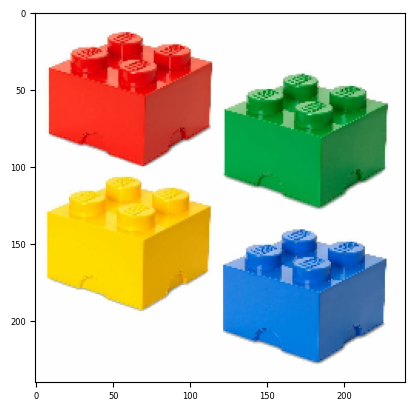

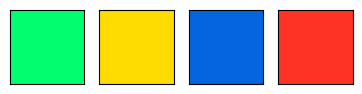

In [36]:
# example 

volume_properties= []
rgb_img = imageio.imread("photos/lego_sample.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties, 4 )

There are  10 Hue peaks
[]  s_pulse_start_end
[]  s_pulse_start_end
[]  s_pulse_start_end
[]  s_pulse_start_end
[]  s_pulse_start_end
[]  s_pulse_start_end
[]  s_pulse_start_end
[49, 51, 62, 68]  s_pulse_start_end
[]  s_pulse_start_end
[]  s_pulse_start_end
[33, 107]  s_pulse_start_end
[28, 29, 37, 38]  s_pulse_start_end
[]  s_pulse_start_end
[]  s_pulse_start_end
there are  6  materials
volume properties [[26889, 0, 93, 107, 95, 255, 1], [22422, 0, 128, 128, 128, 255, 1], [4038, 0, 147, 147, 147, 255, 1], [3359, 0, 105, 112, 101, 255, 1], [2640, 0, 149, 149, 149, 255, 1], [874, 0, 110, 110, 110, 255, 1]]


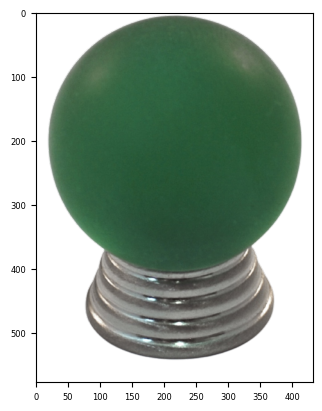

<Figure size 640x480 with 0 Axes>

In [27]:
volume_properties= []
rgb_img = imageio.imread("photos/materials_sample-removebg-preview.png")
plt.imshow(rgb_img)

saved_masked_img=hsv_analysis(rgb_img, 0)


volume_properties.sort( key=lambda x: x[0], reverse=True)    
print('there are ',len(volume_properties),' materials')
print('volume properties', volume_properties)
#show colors in order of importance
show_vp(volume_properties)
    